## PREDICTING CRUDE OIL PRICE

### DATA GATHERING

#### import packages

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error as MSE, r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import register_matplotlib_converters
import warnings



register_matplotlib_converters()
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

2023-01-08 10:57:56.133768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-08 10:57:56.133792: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### read data

In [2]:
# read data and print first few rows
brent = pd.read_csv('Brent.csv', parse_dates = ['Date'])

### DATA WRANGLING

#### make a copy of the data

In [3]:
# make a copy of the data
brent_oil = brent.copy()

#### check for data errors

Data type is correct and there is absence of missing values

In [4]:
# check data information
brent_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8216 entries, 0 to 8215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8216 non-null   datetime64[ns]
 1   Price   8216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.5 KB


In [5]:
brent_oil.tail()

,Date,Price
8211,2019-09-24,64.13
8212,2019-09-25,62.41
8213,2019-09-26,62.08
8214,2019-09-27,62.48
8215,2019-09-30,60.99


we can see a minimum price of 9 dollars and a maximum of 143 dollars. There is no way to tell if they are outliers or inconsistent until we carry out further analysis. Looking at the law of demand, price generally increases as demand increases which is the case for this scenario of oil prices.

In [6]:
# check summary statistics
brent_oil.describe()

,Price
count,8216.000000
mean,46.332605
std,32.704113
min,9.100000
25%,18.730000
50%,31.260000
75%,67.432500
max,143.950000


### EXPLORATORY ANALYSIS


The following blocks of code show the forensic tools prepared to aid in the hunt for major incidents:

+ create a year column
+ set date as index to enable resampling in pandas 
+ data subset based on 20 year period 
+ plot line graph

In [7]:
# create a year column
brent_oil['Year'] = brent_oil.Date.dt.year

# Set date as index so can do resampling using pandas
brent_oil.set_index('Date', inplace=True)

we want to plot a time series graph of the Crude oil prices for the last 20 years with reference to the dataset provided. This will span between 1999 to present (2019). We will create a new subset containing data from 1999 to 2019.

In [8]:
# create subset on a 20-year period
brent_99_19 = brent_oil[brent_oil['Year']>= 1999]

## TASK A

## 1. Data Visualisation: Define simple line chart to give an idea of the stock price change Brent oil price information for the last 20 years

## Brent Crude oil prices prices Between Jan 4 1999 - September 30, 2019

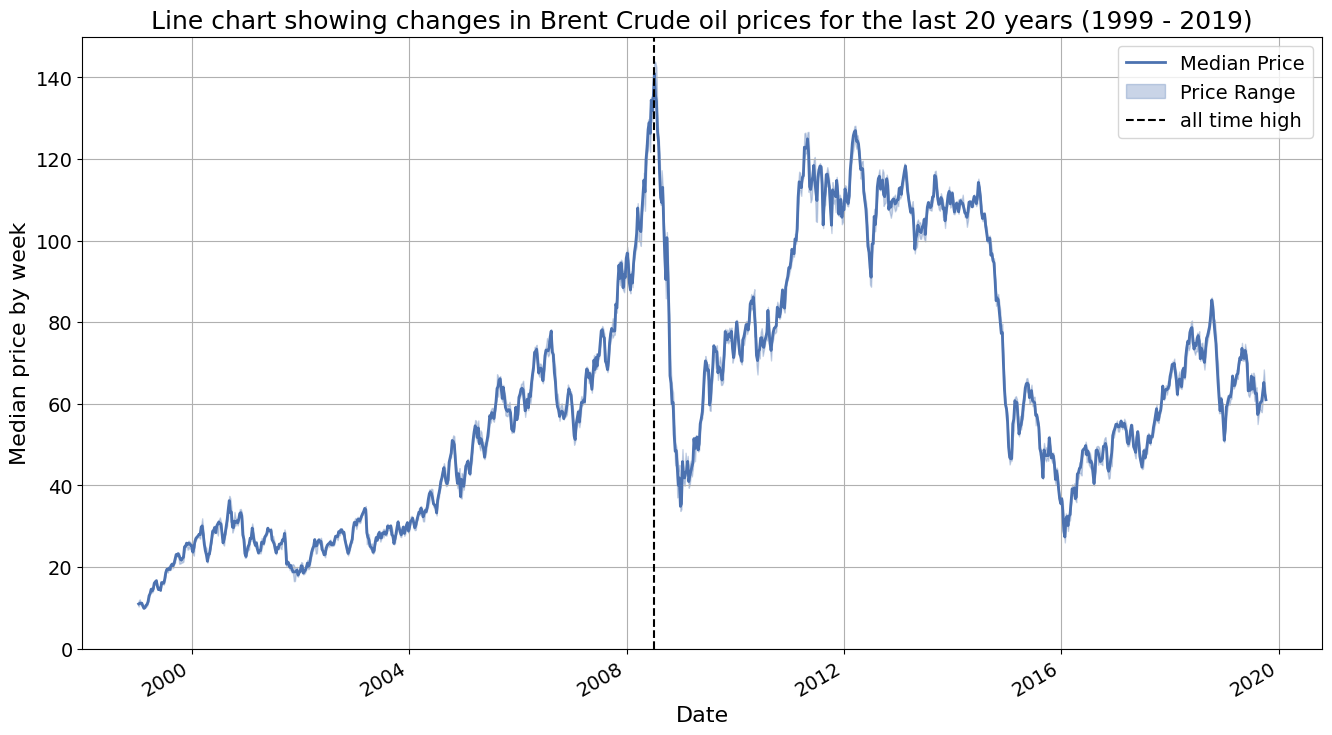

In [9]:
fig, ax =  plt.subplots()

# calculate weekly statistics of price
weekly_median_price = brent_99_19.resample('1W').Price.median()
weekly_max_price = brent_99_19.resample('1W').Price.max()
weekly_min_price = brent_99_19.resample('1W').Price.min()

# plot the time series filling it with some 
# calculated statistics
ax.plot(weekly_median_price.index, weekly_median_price, lw = 2, label = 'Median Price')
ax.fill_between(weekly_median_price.index, weekly_max_price,\
                weekly_median_price, alpha = 0.3,\
                color = 'C0', label = 'Price Range')
ax.fill_between(weekly_median_price.index, weekly_min_price,\
                weekly_median_price, alpha = 0.3,\
                color = 'C0')

# annotate the plot to show significant events
# that led to variation in price
ax.axvline(pd.Timestamp('2008-7-01'), ls = '--', c = 'k', label = 'all time high')

# set axis labels and titles
ax.set_ylabel('Median price by week')
ax.set_xlabel('Date')
ax.set_ylim([0, 150])
plt.title('Line chart showing changes in Brent Crude oil prices for the last 20 years (1999 - 2019)')
ax.legend()
ax.grid()
fig.autofmt_xdate()

## 2. BUILD EXPLANATORY VARIABLES

## Feature Engineering for Machine learning 

Looking at the data of the brent crude oil prices, only one column(Price) which is the traget variable is present apart from the date column. We will need to engineer new features from the available price column to use as our independent variable. Here, we will create 3-day and 9-day moving averages from the price column. According to [Investopedia](https://www.investopedia.com/terms/m/movingaverage.asp), One purpose of computing the moving average of a stock is to create a continuously updated average price that can smooth out the price data. This can help reduce the effect of short-term, random price fluctuations on the stock over a given period of time.

In [10]:
# create a function to calculate 3 day and 9 day
# moving average
def compute_rolling(df, horizon, col):
    label = f'moving_{horizon}_day_avg_{col}'
    df[label] = df[col].rolling(horizon).mean()
    return df

In [11]:
# set the rolling horizon to 3 and 9
rolling_horizon = [3, 9]

# iterate using for loop
for horizon in rolling_horizon:
    for col in ['Price']:
        brent_99_19 = compute_rolling(brent_99_19, horizon, col)

Looking at the new dataframe created, we can see that we have missing values. These row will have to be dropped as maxhine learning models can work with missing values

In [12]:
# lets print head of the new dataframe
brent_99_19.head(10)

,Price,Year,moving_3_day_avg_Price,moving_9_day_avg_Price
Date,,,,
1999-01-04,10.94,1999,NaN,NaN
1999-01-05,10.30,1999,NaN,NaN
1999-01-06,10.67,1999,10.636667,NaN
1999-01-07,11.08,1999,10.683333,NaN
1999-01-08,11.70,1999,11.150000,NaN
1999-01-11,12.07,1999,11.616667,NaN
1999-01-12,11.78,1999,11.850000,NaN
1999-01-13,10.90,1999,11.583333,NaN
1999-01-14,11.10,1999,11.260000,11.171111


In [13]:
# drop rows wih missing values
brent_99_19 = brent_99_19.loc['1999-01-14':]

Variance of the two features are similar so no need to for any transformation

In [14]:
# check variance of the features
brent_99_19[['moving_3_day_avg_Price', 'moving_9_day_avg_Price']].var()

moving_3_day_avg_Price    960.218232
moving_9_day_avg_Price    959.877391
dtype: float64

## Predicting oil price using linear regression

Linear regression is a statistical technique used in data science and machine learning for making predictions about future events. It does this by identifying a linear relationship between an independent variable and a dependent variable. This allows it to use the data it has been given to predict the outcome of future events with a certain level of accuracy. It is a powerful tool that is widely used in a variety of fields, including finance, marketing, and economics.

Linear regression is a type of supervised learning algorithm that can be used to make predictions about continuous or numeric variables, such as sales, salary, age, or product price. It does this by identifying a mathematical relationship between an independent variable and a dependent variable, which is the response or outcome being analyzed or studied. In other words, the regression model uses the data it has been given to predict the value of the dependent variable. This is a useful tool for predicting future events or understanding the relationships between different variables.

There are different types of linear Regression but we will be using the Multiple linear regression with scikit learn.

In multiple linear regression, the equation for predicting the value of a dependent variable is similar to the equation used in simple linear regression, but with additional weights and inputs for the different features being considered. The equation for multiple linear regression looks like this:

y(x) = p0 + p1x1 + p2x2 + … + p(n)x(n)

The machine learning model uses this equation and various weight values to draw lines that best fit the data, and determines the combination of weights that creates the strongest relationship between the variables. To optimize the weights (pi), the regression model uses a cost function called the root mean squared error (MSE) or mean squared error (MSE). This cost function measures the average squared difference between the actual and predicted values of the observations, and produces a single number representing the cost or score associated with the current set of weights. The goal is to minimize the MSE in order to improve the accuracy of the regression model.

## 3. DEFINE TRAIN AND TEST SET

#### SPLIT DATA INTO TRAINING AND TEST SET

We will be splitting the data into 70% train set and 30% test set

In [15]:
# create the feature and target variables
X = brent_99_19.drop(['Year','Price'], axis = 1)
y = brent_99_19.Price

In [16]:
# use train_test_split to split the data into 
# train and test set
X_train, X_test, y_train, y_test = train_test_split( X, y,\
                                                   test_size = 0.3, random_state = 42,\
                                                   shuffle = False)

## Visualize the train and test set ranges

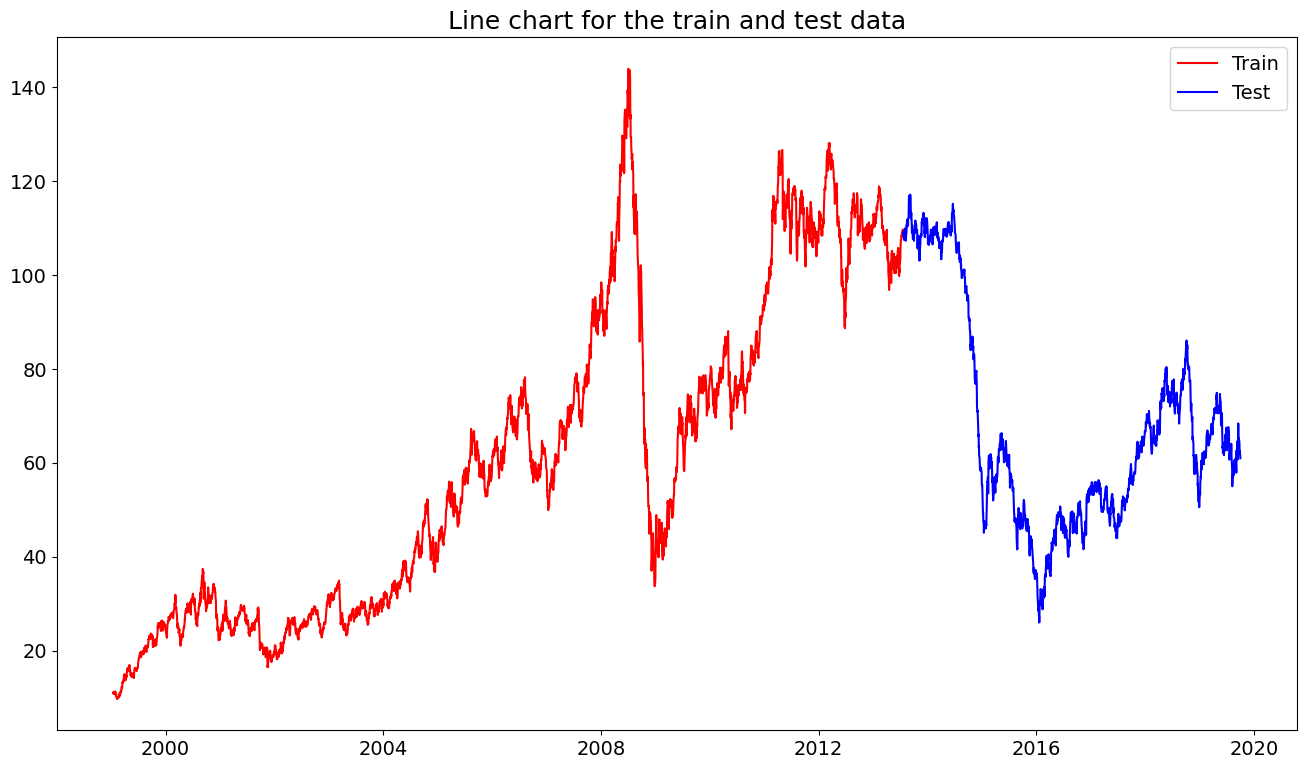

In [17]:
fig, ax = plt.subplots()
ax.plot(X_train.index, y_train, c='r')
ax.plot(X_test.index, y_test, c='b')
plt.title('Line chart for the train and test data')
plt.legend(['Train', 'Test'])

## 4. Build a Linear Regression Model (LR) using the moving averages for the past three (MA3) and nine days (MA9) as inputs;

Linear Regression Parameters

Parameters | Values
---------- | ------
features   | Moving averages (3-day and 9-day) of price
Target     | Price
Data to fit on | train set (X_train, y_train)
Data to predict on | test set (X_test)


In [18]:
# instantiate LinearRegression
linear_reg = LinearRegression()

# fit model on train set
linear_reg.fit(X_train, y_train)


LinearRegression()

## 5. PREDICTION FUNCTION AND RESULT

In this step, run the model using the test data
we defined in step four. Visualise the predicted versus the actual stock values
for the specific time period and calculate the model’s accuracy

In [19]:
# predict on test set
y_pred_linear = linear_reg.predict(X_test)

The Mean Squared Error measures how close a regression line is to a set of data points. It is a risk function corresponding to the expected value of the squared error loss.
A smaller MSE is preferred because it indicates that your data points are dispersed closely around its central moment (mean). It reflects the centralized distribution of your data values, [hrer](https://www.simplilearn.com/tutorials/statistics-tutorial/mean-squared-error#:~:text=The%20Mean%20Squared%20Error%20measures,it%20relates%20to%20a%20function.)

## CALCULATE MODEL'S ACCURACY
We use the following method to measure accuracy of our model
+ mean squared error
+ mean absolute error
+ root mean squared error


In [20]:
# https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
mae = mean_absolute_error(y_test, y_pred_linear)
mse = MSE(y_test, y_pred_linear)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 0.63
Mean squared error: 0.69
Root mean squared error: 0.83


#### CROSS-VALIDATION WITH LINEAR REGRESSION

The previous code block used Linear regression without cross-validation. Lets see if using cross-validation will yield better accuracy

Cross-validation(CV) parameters

Parameters    | Values
----------    | ------
CV type       | Kfold
N_splits      | 5
shuffle       | False
scoring method| cross_val_score
model         | LinearRegression
evaluation metric | negative mean squared error
n_jobs        | -1 (to make use of all computing power)

In [21]:
# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = False)
scores = cross_val_score(linear_reg, X,\
                         y, scoring='neg_mean_squared_error',\
                         cv=folds, n_jobs = -1)
# print the MSE
print('MSE: {}'.format(-scores.mean()))

MSE: 0.838006138281464


The RMSE is slightly higher than that obtained without cross validation but nonetheless, both method indicate that our model fits quite well with the data

In [22]:
# view the RMSE
print('RMSE using cross val is: {}'.format(np.sqrt((-scores).mean())))

RMSE using cross val is: 0.915426752002291


#### VISUALIZE THE PREDICTED PRICE AND THE ACTUAL PRICE FOR THE SPECIFIC TIME PERIOD


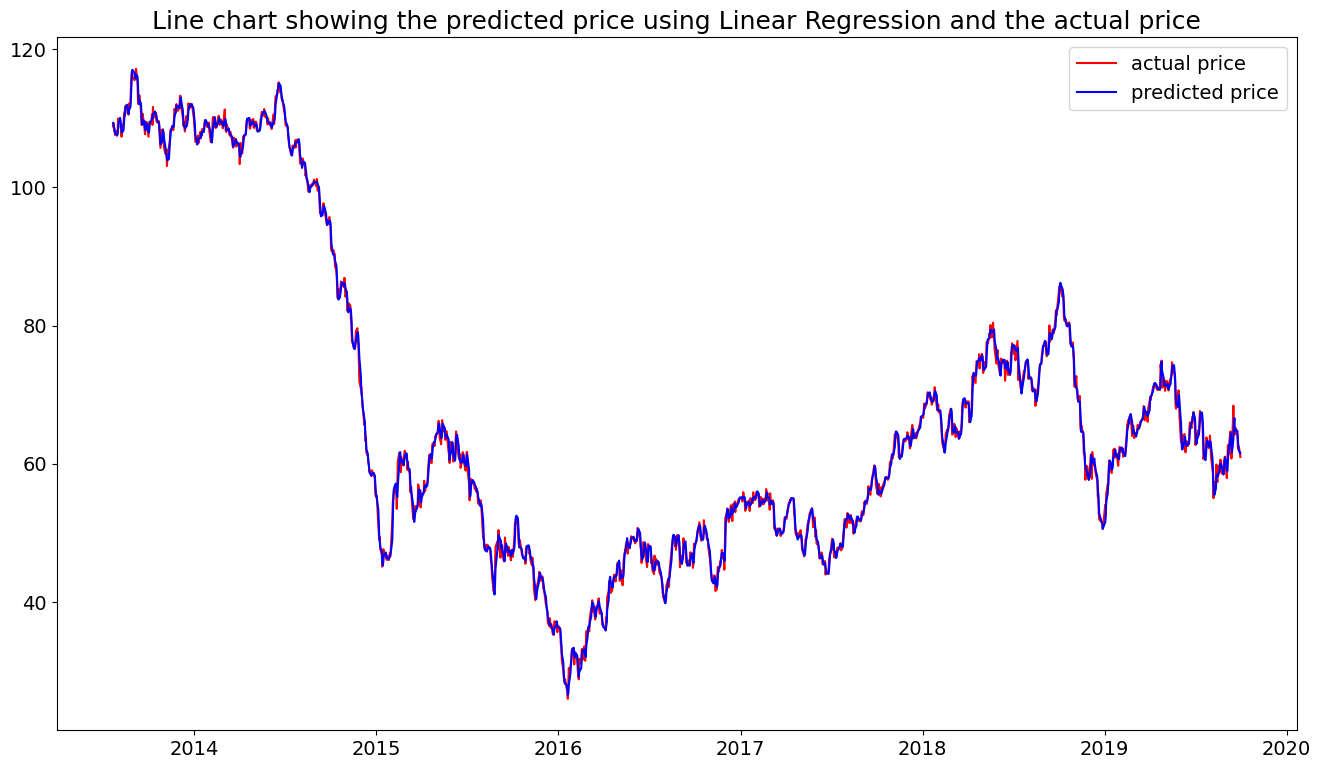

In [23]:
fig, ax = plt.subplots()
ax.plot(X_test.index, y_test, c='r')
ax.plot(X_test.index, y_pred_linear, c='b')
plt.title('Line chart showing the predicted price using Linear Regression and the actual price')
plt.legend(['actual price', 'predicted price']);

## 6. CALCULATE THE ALPHA AND THE BETA VALUES:

Define the linear regression equation using the alpha and betas values

### Get the beta values

In [24]:
# https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
# get feature names and the coefficients
feature_names = X.columns
model_coefficients = linear_reg.coef_

# create  dataframe of features with 
# the corresponding coefficients
coefficients_df = pd.DataFrame(data = np.round(model_coefficients, 3), 
                              index = feature_names, \
                              columns = ['Coefficient value'])
# Print coefficient
print(coefficients_df)


                        Coefficient value
moving_3_day_avg_Price              1.216
moving_9_day_avg_Price             -0.217


### Get the alpha value

In [25]:
# get the intercept
intercept = linear_reg.intercept_
print(np.round(intercept, 3))

0.041


### The linear regression equation is

y = 0.041 + 1.216Xa - 0.217Xb


## PREDICTING OIL PICES USING LONG SHORT-TERM MEMORY

## 1. DEFINE TRAIN AND TEST DATA

With deep learning models, we know that we have to scale our data for optimal performance. We use MinMaxScaler to scale the values between zero and one and then use the fit_transform method to fit the scaler and transform the model.

In [26]:
##We need 2 scalers per model -Train and Test require different scalers
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

#### DEFINE TRAIN AND TEST SET

##### STEP 1
LSTM requires values to be a numpy array and since we are dealing with a time series, the time should sequential as we will be trying to predict future prices based on past prices. we first create our train and test data by subsetting the orignal data.

In order to make predictions based on past data, we need to create a specific data structure that includes information from the previous time stamp since we will be using the moving averages. Therefore, the training data, X_train, is a list of lists containing the prices from the previous time stamp, and the training labels, y_train, are the stock prices for the following day, corresponding to each list in X_train. 

We will reshape the data as LSTM works with 3D array

In [27]:
##Function to Prepare Training Data for LSTM
def prepare_train_data_lstm(scaler,train_data,n_dim):
  input_data = scaler.fit_transform(train_data.values)
  print('Shape of Input Data Initially',input_data.shape)
  timesteps = 1
  global X1
  X1 = []
  global y1
  y1=[]
  for i in range(len(input_data)-timesteps-1):
    t=[]
    for j in range(0,timesteps):        
      
        t.append(input_data[[(i+j)], :])
    X1.append(t)
    y1.append(input_data[i+ timesteps,0])
  
  X1, y1= np.array(X1), np.array(y1)
  print('Shape of Train Part after transformation',X1.shape)
  print('Shape of Test Part after transformation ',y1.shape)
  
  X1 = X1.reshape(X1.shape[0],timesteps, n_dim)
  print('Final Shape ',X1.shape)
  return X1,y1

In [28]:
##Function to Prepare Test Data
def prepare_test_data_lstm(scaler,test_data,n_dim):
  inputs = scaler.transform(test_data.values)
  global X1_test
  X1_test = []
  timesteps = 1
  for i in range(len(inputs)-timesteps-1):
      t=[]
      for j in range(0,timesteps):
        
          t.append(inputs[[(i+j)], :])
      X1_test.append(t)
  X1_test = np.array(X1_test)
  X1_test = np.reshape(X1_test, (X1_test.shape[0], X1_test.shape[1], n_dim))
  print('Shape of Test Dataset',X1_test.shape)
     

In [29]:
X1,y1 = prepare_train_data_lstm(sc1,X_train,2)

Shape of Input Data Initially (3679, 2)
Shape of Train Part after transformation (3677, 1, 1, 2)
Shape of Test Part after transformation  (3677,)
Final Shape  (3677, 1, 2)


In [30]:
prepare_test_data_lstm(sc1,X_test,2)

Shape of Test Dataset (1576, 1, 2)


## 2.  BUILD LSTM MODEL

A sophisticated RNN, or sequential network, called a long short term memory network, permits information to endure. It is capable of resolving the RNN's vanishing gradient issue. RNNs, also referred to as recurrent neural networks, are utilized for persistent memory.
Due to diminishing gradient, RNN have the flaw of being unable to recall long-term dependencies. Long-term dependency issues are specifically avoided when designing LSTMs. LSTM consist of three gates known as GATES comprising of the input, output and forget gate.
The forget gate chooses whether the information coming from the previous timestamp is to be remembered or is irrelevant and can be forgotten. In input gate, the cell tries to learn new information from the input to this cell. At last, in the output gate, the cell passes the updated information from the current timestamp to the next timestamp. The equations for the forget, input and output gate are written below where; 
+ x represent input to the current timestamp.
+ U represent weight associated with the input
+ Ht-1 represent The hidden state of the previous timestamp
+ W  is the weight matrix associated with hidden state:

forget date Equation
+ fₜ = σ(xₜ * Uₛ + Ht-1 * Wₛ)

Input Gate Equation
+ Iₜ = σ(xₜ * Uᵢ + Ht-1 * Wᵢ)

Output Gate Equation
+ Oₜ = σ(xₜ * Uₒ + Ht-1 * Wₒ)


Fundamentally, we are building a Neural network regressor for continuous value prediction using LSTM. We instantiate the model and Then, add the 1st LSTM layer with the Dropout layer followed. We will add 3 more layers to the neural network. Finally, add the output layer. To compile the RNN, we will select an SGD algorithm and a loss function. Adam is a commonly used optimizer, so it is a good choice to begin with. The loss function will be the average of the squares of the differences between the predicted values and the actual values.

### LSTM parameters
Parameters         | Values
------------------ | ------------- 
units              | 30
return_sequence    | set to True for input layer and first two hidden layes
Dropout            | 0.2
Optimizer          | Adam
Loss Function      | Mean squared error
Epoch              | 50
Batch Size         | 32
Scaler             | MinMaxScaler
imput shape        | shape of train data
feature variable   | Moving averages (3-day and 9-day) for price 
Target Variable    | Price




In [31]:
##LSTM Model Function
def lstm_model(scaler,train_data,n_dim):
#initialize model
  prepare_train_data_lstm(scaler,train_data,n_dim)

  global model
  model = Sequential()
 
#layer 1 of LSTM
  model.add(LSTM(units=30,return_sequences=True,input_shape=(X1.shape[1],n_dim)))
  model.add(Dropout(0.2))
 
#layer 2 of LSTM
  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))
 
#layer 3 of LSTM
  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))


#layer 4 of LSTM
  model.add(LSTM(units=30))
  model.add(Dropout(0.2))
 
#Output layer of model
  model.add(Dense(units=1))

  optimizer = tf.keras.optimizers.Adam(lr=2e-5)
#compiling the model
  model.compile(optimizer=optimizer,loss='mean_squared_error')
  model.fit(X1, y1, epochs=50, batch_size=32)

In [32]:
lstm_model(sc1,X_train,2)

Shape of Input Data Initially (3679, 2)
Shape of Train Part after transformation (3677, 1, 1, 2)
Shape of Test Part after transformation  (3677,)
Final Shape  (3677, 1, 2)


2023-01-08 10:58:01.216563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-08 10:58:01.216589: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-08 10:58:01.216609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8a866978-8706-48f3-8507-79791cc5c69f): /proc/driver/nvidia/version does not exist
2023-01-08 10:58:01.216865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
115/115 [==============================] - 6s 10ms/step - loss: 0.2063
Epoch 2/50
115/115 [==============================] - 1s 7ms/step - loss: 0.2007
Epoch 3/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1949
Epoch 4/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1886
Epoch 5/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1818
Epoch 6/50
115/115 [==============================] - 1s 7ms/step - loss: 0.1745
Epoch 7/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1663
Epoch 8/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1575
Epoch 9/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1479
Epoch 10/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1378
Epoch 11/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1265
Epoch 12/50
115/115 [==============================] - 1s 6ms/step - loss: 0.1151
Epoch 13/50
115/115 [===

## 3. PREDICTION FUNCTION AND RESULTS

In [33]:
# function to predict price
def predict_data(model_name,scaler_pred,test_data,X1_test,n_dim):
  
  pred = model_name.predict(X1_test)
  print(len(test_data[1:]))
  set_scale = scaler_pred.fit_transform(test_data.iloc[1:,0].values.reshape(-1,1))
  pred_descale = scaler_pred.inverse_transform(pred)
  global pred_df
  pred_df = pd.DataFrame(pred_descale,columns=['Predicted'])
  return pred_df

In [34]:
# predict price 
predict_data(model,sc2,X_test,X1_test,2)

50/50 [==============================] - 1s 2ms/step
1577


,Predicted
0,89.162994
1,89.147881
2,89.015648
3,88.886261
4,88.613777
...,...
1571,60.074963
1572,60.105461
1573,60.129574
1574,59.945629


In [35]:
# make a copy of the predicted values and 
# subset 
data_out_pred = pred_df.copy()
data_out_actual = X_test.iloc[2:,0].copy()

In [40]:
# Function to Calculate Result Metrics and plot 
# predicted values and actual values
def result_metrics_forecast(test_series,forecast_series,model_name):
  print('Result Metrics for ' +  str(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(MSE(test_series,forecast_series),3))
  print('Root Mean Squared Error : ',np.sqrt(round(MSE(test_series,forecast_series),3)))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  fig = plt.figure(figsize=(10,10))
  plt.plot(test_series.index,test_series,label='Actual')
  plt.plot(test_series.index,forecast_series,label='Predicted')
  plt.title('Line chart showing the pridicted price using ' + str(model_name) + ' and the actual price')
  plt.ylabel('Price')
  plt.legend()

## Visualize the actual price and the predicted price

Result Metrics for LSTM
R2 Score :  0.795
Mean Squared Error :  106.443
Root Mean Squared Error :  10.317121691634735
Mean Absolute Error :  7.968


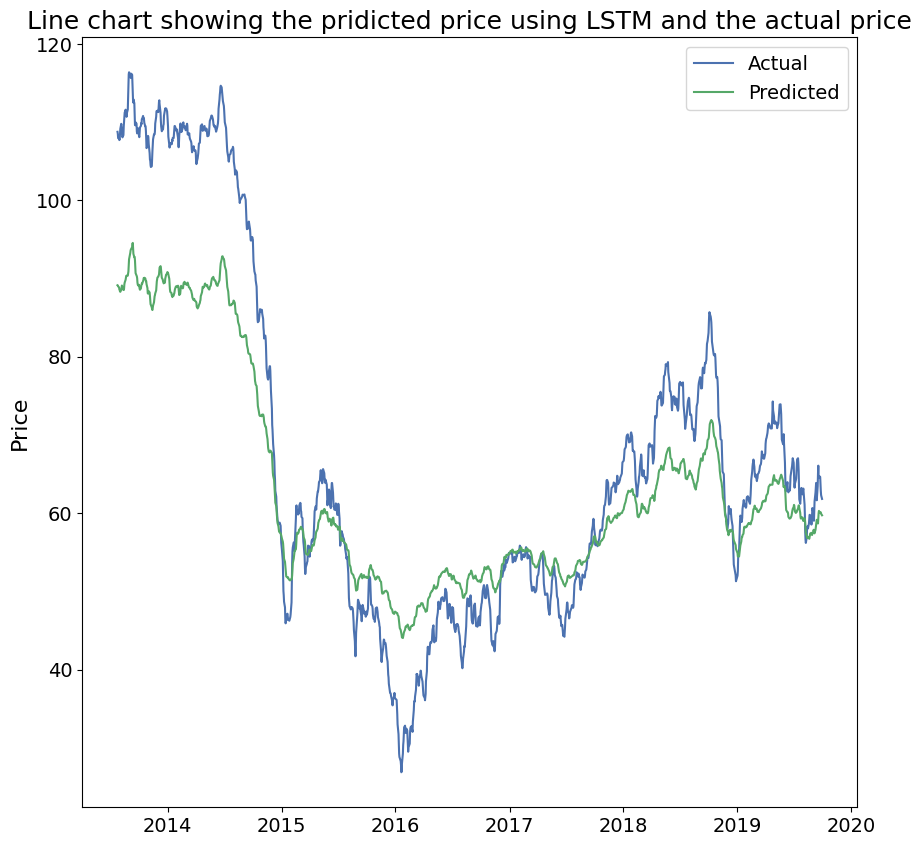

In [41]:
# calculate the evaluation metrics and plot
# the graph of predicted and actual values
result_metrics_forecast(data_out_actual,data_out_pred,'LSTM')